In [1]:
import pyspark                    # load PySpark so we can use Spark in Python
print(pyspark.__version__)        # check which PySpark version is installed


3.5.1


In [31]:
from pyspark.sql import SparkSession  # import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("TestSpark") \
    .getOrCreate()  # no spaces after the backslash

spark  # display Spark session info


In [13]:
files = [
    r"C:\Users\HP\Downloads\nyc_taxi\taxi_trip_data.csv",
    r"C:\Users\HP\Downloads\nyc_taxi\taxi_zone_geo.csv",
    r"C:\Users\HP\Downloads\nyc_taxi\original_cleaned_nyc_taxi_data_2018.csv"
]

df = spark.read.csv(files, header=True, inferSchema=True)
df.show(5)


+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----+-----------+------------+------------+-------------+------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type| fare_amount|extra|    mta_tax|  tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----+-----------+------------+------------+-------------+------------+------------------+-------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1| 18.150000000|        3|                 N|           1|70.000000000| 0E-9|       0E-9|16.160000000|10.500000000|  0.300000000|96.960000000|               161|                  1|
|        2|2

In [14]:
# Show first 5 rows
df.show(5)

# Show schema to check column types
df.printSchema()

# Count missing values in each column
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----+-----------+------------+------------+-------------+------------+------------------+-------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type| fare_amount|extra|    mta_tax|  tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----+-----------+------------+------------+-------------+------------+------------------+-------------------+
|        2|2018-03-29 13:37:13|2018-03-29 14:17:01|              1| 18.150000000|        3|                 N|           1|70.000000000| 0E-9|       0E-9|16.160000000|10.500000000|  0.300000000|96.960000000|               161|                  1|
|        2|2

In [15]:
from pyspark.sql.functions import col, unix_timestamp, hour

# Trip duration in minutes
df = df.withColumn("trip_duration", 
                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime"))/60)

# Pickup hour
df = df.withColumn("pickup_hour", hour("pickup_datetime"))

df.select("pickup_datetime", "dropoff_datetime", "trip_duration", "pickup_hour").show(5)


+-------------------+-------------------+-----------------+-----------+
|    pickup_datetime|   dropoff_datetime|    trip_duration|pickup_hour|
+-------------------+-------------------+-----------------+-----------+
|2018-03-29 13:37:13|2018-03-29 14:17:01|             39.8|         13|
|2018-03-29 13:37:18|2018-03-29 14:15:33|            38.25|         13|
|2018-03-29 13:26:57|2018-03-29 13:28:03|              1.1|         13|
|2018-03-29 13:07:48|2018-03-29 14:03:05|55.28333333333333|         13|
|2018-03-29 14:19:11|2018-03-29 15:19:59|             60.8|         14|
+-------------------+-------------------+-----------------+-----------+
only showing top 5 rows



In [16]:
df.groupBy("pickup_hour").count().orderBy("pickup_hour").show()


+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|       NULL|8320191|
|          0| 357645|
|          1| 214869|
|          2| 141666|
|          3| 115663|
|          4| 129437|
|          5| 143626|
|          6| 214900|
|          7| 321877|
|          8| 412201|
|          9| 447902|
|         10| 455367|
|         11| 477872|
|         12| 512661|
|         13| 522041|
|         14| 566572|
|         15| 570318|
|         16| 541945|
|         17| 566225|
|         18| 565141|
+-----------+-------+
only showing top 20 rows



In [17]:
df.groupBy("pickup_hour").avg("trip_duration").show()


+-----------+------------------+
|pickup_hour|avg(trip_duration)|
+-----------+------------------+
|         12|  36.5770452274182|
|         22|30.314335242948086|
|          1|28.954979157843418|
|         13| 37.24216137557532|
|         16| 43.69906017523313|
|          6| 35.73187684194196|
|          3|27.271884123127805|
|         20|31.523731004936277|
|          5| 30.23058499157531|
|         19|  33.3176665726347|
|         15| 42.39437626610655|
|         17|42.343921880289194|
|          9|37.525169568343266|
|          4|27.619152689467988|
|          8| 38.64578328695636|
|         23|29.859820150666447|
|          7| 39.10799073352031|
|         10| 36.68517210660131|
|         21|30.935568211838323|
|         11|  36.5720381189943|
+-----------+------------------+
only showing top 20 rows



In [20]:
df.groupBy("pickup_location_id").count().orderBy(col("count").desc()).show(10)


+------------------+-------+
|pickup_location_id|  count|
+------------------+-------+
|               138|2141003|
|               132| 936700|
|                 3| 910734|
|                 5| 762923|
|                10| 751453|
|                 4| 736156|
|                 6| 719914|
|                12| 697799|
|                11| 672555|
|                 9| 658065|
+------------------+-------+
only showing top 10 rows



In [22]:
import matplotlib
import seaborn as sns

print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)


Matplotlib version: 3.10.7
Seaborn version: 0.13.2


C:\Users\HP\AppData\Local\Temp\ipykernel_40860\2515947526.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pickup_location_id", y="count", data=top_pickups, palette="viridis")


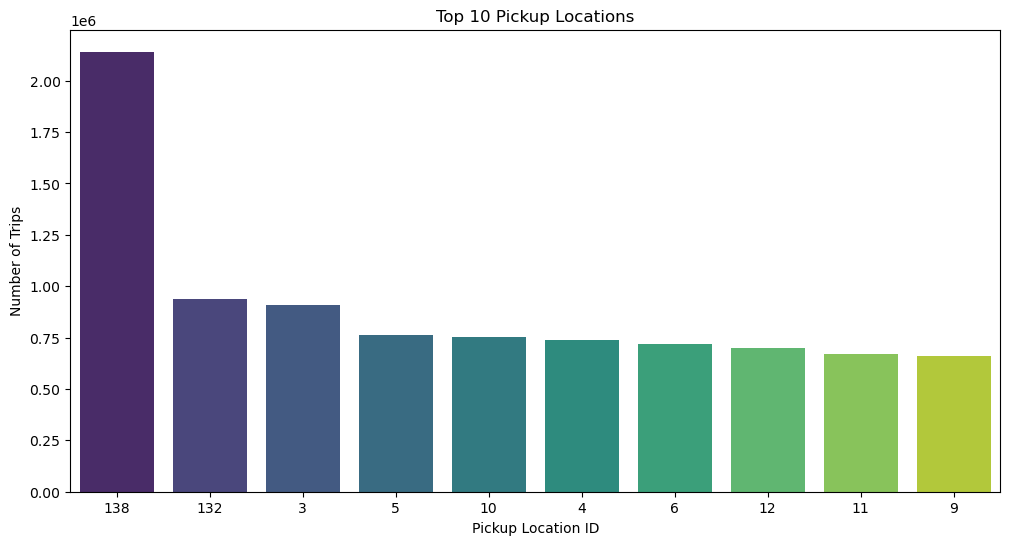

In [23]:
top_pickups = df.groupBy("pickup_location_id") \
                .count() \
                .orderBy(col("count").desc()) \
                .limit(10) \
                .toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x="pickup_location_id", y="count", data=top_pickups, palette="viridis")
plt.title("Top 10 Pickup Locations")
plt.xlabel("Pickup Location ID")
plt.ylabel("Number of Trips")
plt.show()


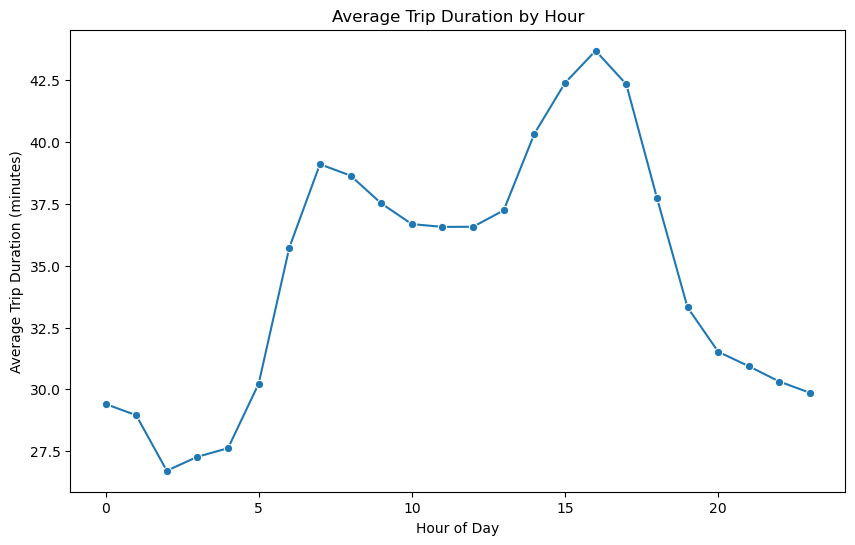

In [24]:
avg_duration = df.groupBy("pickup_hour").avg("trip_duration").orderBy("pickup_hour")
avg_duration_pd = avg_duration.toPandas()

plt.figure(figsize=(10,6))
sns.lineplot(x="pickup_hour", y="avg(trip_duration)", data=avg_duration_pd, marker="o")
plt.title("Average Trip Duration by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trip Duration (minutes)")
plt.show()
